# Introduction

The objectives of this lab are
- Development of a classification model based on artificial neural networks for the fall detection dataset CAUCA,
- Use TensorFlow to determine a performant CNN architecture,
- Study of the architecture of a neural network and the sensitivity of its parameters,
- Use TensorFlow Lite to compress the CNN,
- (Optional) Implementation of Transfer Learning using an efficient architecture (e.g. MobileNetV2).

In [8]:
# # To run on the machines at INSA, this should be enough using anaconda:
# conda create -n 5ISS_ML2 python=3.9 -y
# conda activate 5ISS_ML2
# pip install ipykernel
# pip install tensorflow==2.15.1
# pip install tensorflow_model_optimization==0.7.5
# pip install matplotlib scikit-learn seaborn opencv-python
# python -m ipykernel install --user --name=5ISS_ML2 --display-name "Python (5ISS_ML2)"

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from keras.models import Sequential, save_model, clone_model, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.saving import load_model

# TensorFlow Optimization
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude, PolynomialDecay, UpdatePruningStep, ConstantSparsity

import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import tempfile
import os
import zipfile
import math
import pickle
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.model_selection import train_test_split

In [10]:
import os.path

url = 'https://insatoulousefr-my.sharepoint.com/:u:/g/personal/leleux_insa-toulouse_fr/EVVcm7XlSMtMpLqYjW_d1bgBSsvO0jiNkI6jnflT3SSKoA?e=xM2REJ'
file_Path = 'data_train_96_96_3.pickle'
if not os.path.isfile(file_Path):
    print(f"please download the file {file_Path} from:")
    print(url)

url = 'https://insatoulousefr-my.sharepoint.com/:u:/g/personal/leleux_insa-toulouse_fr/EX-ocfOdwJ5Hoy4yDbD9wCQBxIdzKStTI5K68nNke2-uyQ?e=69mEe2'
file_Path = 'data_train_96_96_3.pickle'
if not os.path.isfile(file_Path):
    print(f"please download the file {file_Path} from:")
    print(url)

url = 'https://insatoulousefr-my.sharepoint.com/:u:/g/personal/leleux_insa-toulouse_fr/ES2Owkp7J9tGrLBwYW4Brh0BQKe5AmeNe6OwSz7NHGEEbw?e=4UcOk9'
file_Path = 'data_test_96_96_3.pickle'
if not os.path.isfile(file_Path):
    print(f"please download the file {file_Path} from:")
    print(url)

# 1. Classification of the CAUCA dataset using Convolutional Neural Networks (CNN)

TensorFlow is an open-source machine learning library developed by Google, primarily used for deep learning applications. It provides a comprehensive, flexible ecosystem of tools, libraries, and community resources that enables researchers to develop and deploy machine learning powered applications easily. We use the Python version of the library which can be installed in Python with:
*pip install tensorflow*

We will use the library **tensorflow.keras** to develop ANN of type Convolutional Neural Netowrks (CNN). We use the generic class **Sequential** combined with layers of types:
- **Conv2D**,
- **MaxPooling2D**,
- **BatchNormalization**,
- **Dropout**,
- **Flatten**,
- **Dense**.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*uAeANQIOQPqWZnnuH-VEyw.jpeg" alt="CNN example" />

The documentation for the Tensorflow layers is available at https://www.tensorflow.org/api_docs/python/tf/keras/layers.
Since an example is better than 1000 words, below is a fully working example code for a toy classification problem.

## 1.1 Hand-drawn shapes (HDS) dataset

Some datasets are available on the internet (search Google, Kaggle, and scientific articles). Here, we focus on a small example dataset extracted from the repository: https://github.com/frobertpixto/hand-drawn-shapes-dataset/tree/main. This dataset contains 70x70px images (in .png format) in grayscale of hand-drawn shapes. The images can be of 4 classes: ellipse, triangle, rectangle, others. There are around 50 000 images available. Processing codes are available on github to preprocess the pictures, and build a CNN model for classification.

<img src="https://raw.githubusercontent.com/frobertpixto/hand-drawn-shapes-dataset/main/readme_images/train_images.png" alt="HDS example" />

We have modified the processing code from the repository in order to reduce the dataset for our purpose:
- The images are resized to 14x14px,
- We only keep the classes ellipse, triangle, and rectangle,
- We keep 4 500 images.

The dataset is stored in a pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'train_data': train_data,*
        *'train_labels': train_labels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

- Load data
- N.B.: In the obtained labels y, class 1="ellipse", class 2="rectangle", class 3="triangle"

In [11]:
with open("hds_data.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X = train_dict['train_data']
y = train_dict['train_labels'] - 1

Image:  1224


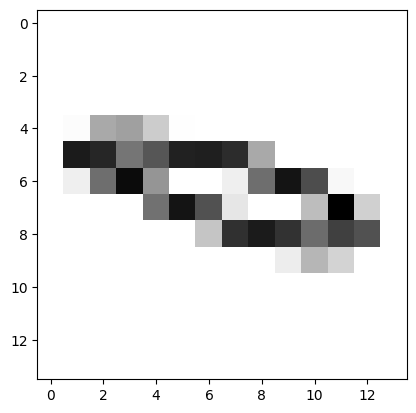

In [12]:
ind = random.randint(0, len(X))
print("Image: ",ind)
plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

- **Normalize the images**

In [13]:
from sklearn.preprocessing import StandardScaler

N, H, W = X.shape
images_flat = X.reshape(N, -1)

# Apply scaler
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

# Reshape back
X = images_flat_scaled.reshape(N, H, W)

Image:  3507


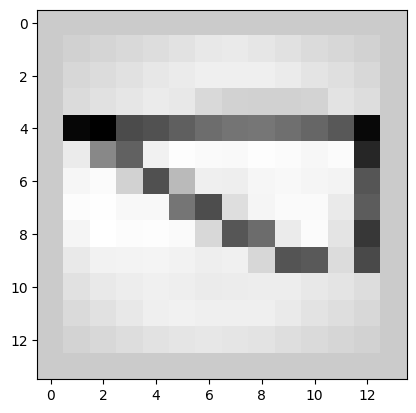

In [14]:
ind = random.randint(0, len(X))
print("Image: ",ind)
plt.imshow(X[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

- **Visualize the groups of images as clusters**

In [15]:
N, H, W = X.shape
X_flat = X.reshape(N, H * W)

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_flat)

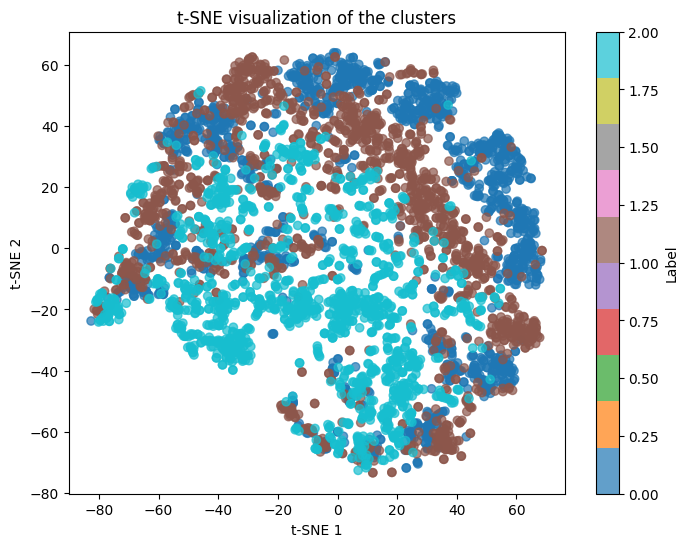

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Label')
plt.title("t-SNE visualization of the clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

- **Split into train and test datasets**

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8)

# Reshape and normalize the images
xtrain = xtrain.reshape((xtrain.shape[0], 14, 14, 1)).astype('float32')
xtest = xtest.reshape((xtest.shape[0], 14, 14, 1)).astype('float32')

# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

- **Create the model**

In [19]:
# Building the CNN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(14, 14, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 12, 12, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 12, 12, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 32)                36896     
                                                                 
 dense_1 (Dense)             (None, 3)                 9

2025-07-08 00:04:06.506780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-08 00:04:06.577012: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


- **Compile and train the model**

In [20]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, batch_size=128)

Epoch 1/10
29/29 [==============================] - 1s 6ms/step - loss: 0.9305 - accuracy: 0.6281 - val_loss: 0.9471 - val_accuracy: 0.7178
Epoch 2/10
29/29 [==============================] - 0s 3ms/step - loss: 0.5167 - accuracy: 0.7869 - val_loss: 0.8568 - val_accuracy: 0.7289
Epoch 3/10
29/29 [==============================] - 0s 3ms/step - loss: 0.4040 - accuracy: 0.8403 - val_loss: 0.7877 - val_accuracy: 0.7567
Epoch 4/10
29/29 [==============================] - 0s 3ms/step - loss: 0.3334 - accuracy: 0.8719 - val_loss: 0.7118 - val_accuracy: 0.7689
Epoch 5/10
29/29 [==============================] - 0s 3ms/step - loss: 0.2954 - accuracy: 0.8881 - val_loss: 0.6491 - val_accuracy: 0.7767
Epoch 6/10
29/29 [==============================] - 0s 3ms/step - loss: 0.2392 - accuracy: 0.9094 - val_loss: 0.5647 - val_accuracy: 0.8178
Epoch 7/10
29/29 [==============================] - 0s 3ms/step - loss: 0.2040 - accuracy: 0.9303 - val_loss: 0.5207 - val_accuracy: 0.8111
Epoch 8/10
29/29 [==

- **TODO: Evaluate the model (this will help you later):**
    - display a random image in the test set with its true and predicted labels,
    - display the accuracy of the CNN on the train and test sets,
    - compute and display the confusion matrix of the model,
    - display the evolution of the accuracy over the training iterations of the CNN.

In [21]:
# TODO

29/29 [==============================] - 0s 1ms/step


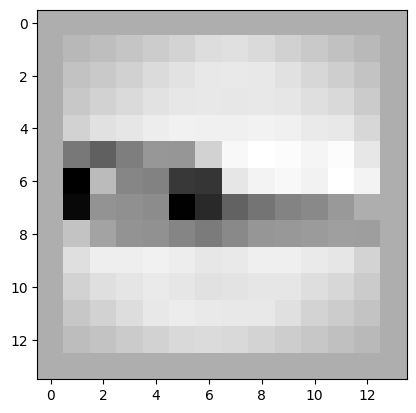

[0. 1. 0.]
[0.12924285 0.4956795  0.3750777 ]


In [22]:
#SOLUTION
ypred = model.predict(xtest)
ind = random.randint(0, len(xtest))
plt.imshow(xtest[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()
print(ytest[ind])
print(ypred[ind])

In [23]:
#SOLUTION
train_loss, train_acc = model.evaluate(xtrain, ytrain)
print('Train accuracy:', train_acc)
test_loss, test_acc = model.evaluate(xtest, ytest)
print('Test accuracy:', test_acc)

113/113 [==============================] - 0s 1ms/step - loss: 0.2943 - accuracy: 0.9219
Train accuracy: 0.9219444394111633
29/29 [==============================] - 0s 1ms/step - loss: 0.3931 - accuracy: 0.8533
Test accuracy: 0.8533333539962769


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


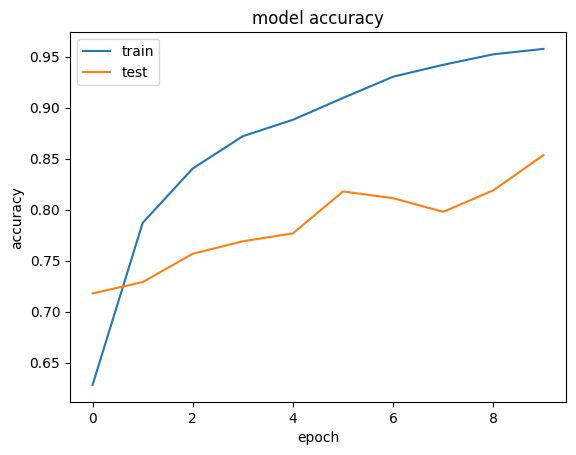

In [24]:
# SOLUTION
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

- **TODO: Questions:**
    - look at the documentation of Tensorflow and exmaplin briefly what is the a *Dropout* layer.
    - what does the *to_categorical* function do and why do we modify the labels (ground truth) with it ?
    - what is contained in the prediction for any example ?
    - Is there any underfitting/overfitting happening when training your model ?

In [25]:
model.save("best_CNN.keras")
model2 = load_model("best_CNN.keras")

## 1.2 Classification of the CAUCA dataset

Goal: adapt the example of the HDS dataset classification above to build a performant classifier for the CAUCA dataset. Be creative and do not hesitate to explore CNN architectures !

For example, you can implement the CNN architecture shown above in the picture of the part 2 on CNN.

### CAUCA fall detection dataset

The CAUCA dataset is avalaible at:
https://data.mendeley.com/datasets/7w7fccy7ky/4
The dataset of falls contains data from 10 different activities: Fall backwards, fall forward, fall left, fall right, fall sitting, hop, kneel, pick up object, sit down, walk.
The 20000 labelled images were obtained from videos taken in conditions of an uncontrolled home environment (occlusions, lights, clothes, etc.).
Each of the 10 subjects had to follow a specific protocol, containing the 10 different "activities".

<img src="CAUCA_ex.jpeg" alt="HDS example" />

We have preprocessed the images for a better classification:
- A YOLO model was used to segment the person in each picture, resulting in square images of size ranging between 200 and 350,
- The images were resized to be 96 × 96 or 224 x 224,
- Labels are merged to get : fall vs. non-fall activity.

The datasets are stored in pickle file which allows to drop Python data structures to a binary file. The structure is a dictionnary with the data X at key "train_data", and the labes y at key "train_labels":
- Storing:
*save_to_pickle(*
    *"train.pickle",*
    *{*
        *'train_data': train_data,*
        *'train_labels': train_labels,*
        *'width': width,*
        *'height': height,*
        *'channels': channels*
    *}*
*)*
- Loading
*with open("train.pickle", 'rb') as file:*
    *train_dict = pickle.load(file)*

Four sets are available
- Training set (data_train_w_h_c.pickle): images of subjects 1-8,
- Final est set (data_test_w_h_c.pickle): images of subjects 9 and 10.

- **TODO: Explore the training data of images 96 x 96 px**
    - load the data from the corresponding pickle file
    - display an image of the train set for each label (0: non-fall, 1: fall) and display the label
    - split the data into train and validation set
    - transform the labels with *to_categorical*

In [26]:
# TODO

In [27]:
# SOLUTION
with open("data_train_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X_complete = train_dict['data']
for i,x in enumerate(X_complete):
    X_complete[i] = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
# y_complete = train_dict['labels'][BATCH]
y_complete = train_dict['labels']
width = train_dict['width']
height = train_dict['height']
channels = train_dict['channels']

0


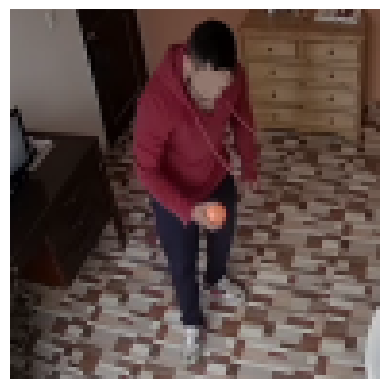

1


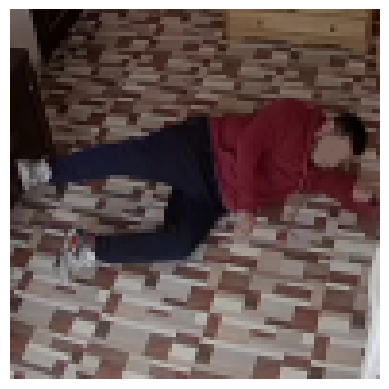

In [28]:
# SOLUTION
fall=y_complete.index(0)
print(y_complete[fall])
plt.imshow(X_complete[fall])
plt.axis('off')
plt.show()

nonfall=y_complete.index(1)
print(y_complete[nonfall])
plt.imshow(X_complete[nonfall])
plt.axis('off')
plt.show()

In [29]:
from sklearn.preprocessing import StandardScaler

N, H, W, C = X_complete.shape
images_flat = X_complete.reshape(N, -1)

# Apply scaler
scaler = StandardScaler()
images_flat_scaled = scaler.fit_transform(images_flat)

# Reshape back
X_complete = images_flat_scaled.reshape(N, H, W, C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.122742287699628..1.6939103355794616].


Image:  5286


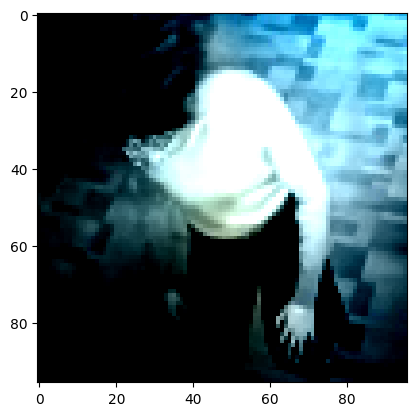

In [30]:
ind = random.randint(0, len(X_complete))
print("Image: ",ind)
plt.imshow(X_complete[ind],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()

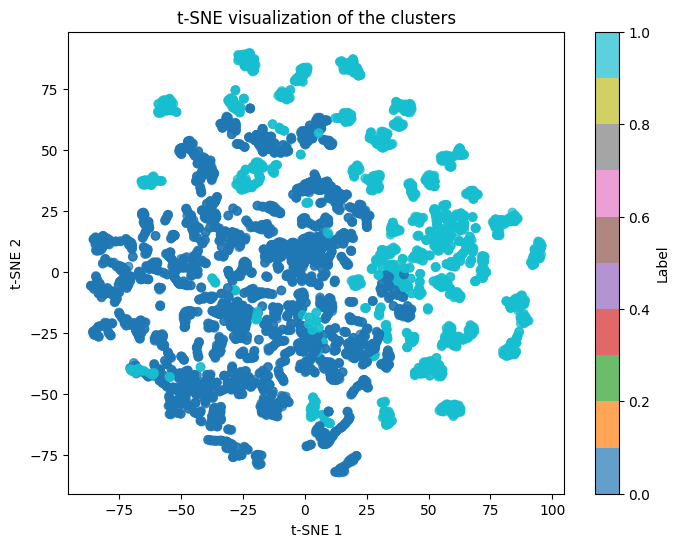

In [31]:
N, H, W, C = X_complete.shape
X_flat = X_complete.reshape(N, H * W * C)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_flat)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_complete, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Label')
plt.title("t-SNE visualization of the clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [32]:
# SOLUTION
xtrain, xtest, ytrain, ytest = train_test_split(X_complete, y_complete, train_size=0.8)

In [33]:
# SOLUTION
# Convert labels to categorical (one-hot encoding)
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

- **TODO: Build a CNN classifier for fall detection**
    - Propose (at least) 3 CNN models with different architectures and parameters (use the lecture and be creative). You can vary e.g.:
        - the number/type of convolution layers
        - the activation functions
        - the size of the kernels, padding and stride
        - the size of the dense layer
        - Constraint: less than 5 million parameters !!!
    - Put them in a list
    - Show for each the number of parameters, and compile the models

In [34]:
# SOLUTION
# Building the CNN model
# model1 = Sequential([
#     Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(height, width, channels), padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(2, activation='softmax')
# ])
# model2 = Sequential([
#     Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(height, width, channels), padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(32, kernel_size=(5, 5), activation='relu', padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(2, activation='softmax')
# ])
# model3 = Sequential([
#     Conv2D(32, kernel_size=(3, 3), activation='tanh', input_shape=(height, width, channels), padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(32, kernel_size=(3, 3), activation='tanh', padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(64, activation='tanh'),
#     Dense(2, activation='softmax')
# ])
# model4 = Sequential([
#     Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(height, width, channels), padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Conv2D(32, kernel_size=(5, 5), activation='relu', padding='valid'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(2, activation='softmax')
# ])
model5 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(height, width, channels)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

# models=[model1, model2, model3, model4]
models=[model5]

In [35]:
#SOLUTION
for model in models:
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_1 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 batch_normalization_2 (Bat  (None, 45, 45, 32)        128       
 chNormalization)                                                
                                                      

In [36]:
# SOLUTION
for model in models:
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

- **Training the models**
    - Actual training = fit with 5 epochs (can take some time depending on your architecture),
    - Do not forget to pass the argument *validation_data*,
    - Store the outputs (history) !

In [37]:
# TODO

In [38]:
#SOLUTION
# Train the models
histories = []
for model in models:
    history = model.fit(xtrain, ytrain, validation_data=(xtest, ytest), epochs=10, batch_size=128)
    histories.append(history)

Epoch 1/10
40/40 [==============================] - 5s 118ms/step - loss: 0.6528 - accuracy: 0.8218 - val_loss: 0.3298 - val_accuracy: 0.9175
Epoch 2/10
40/40 [==============================] - 5s 113ms/step - loss: 0.0519 - accuracy: 0.9825 - val_loss: 0.3425 - val_accuracy: 0.8849
Epoch 3/10
40/40 [==============================] - 4s 112ms/step - loss: 0.0151 - accuracy: 0.9934 - val_loss: 0.2808 - val_accuracy: 0.9341
Epoch 4/10
40/40 [==============================] - 4s 113ms/step - loss: 0.0100 - accuracy: 0.9958 - val_loss: 0.2457 - val_accuracy: 0.9516
Epoch 5/10
40/40 [==============================] - 5s 114ms/step - loss: 0.0073 - accuracy: 0.9972 - val_loss: 0.2041 - val_accuracy: 0.9587
Epoch 6/10
40/40 [==============================] - 5s 113ms/step - loss: 0.0059 - accuracy: 0.9976 - val_loss: 0.1666 - val_accuracy: 0.9722
Epoch 7/10
40/40 [==============================] - 5s 113ms/step - loss: 0.0054 - accuracy: 0.9980 - val_loss: 0.1127 - val_accuracy: 0.9841
Epoch 

- **TODO: Evaluate the models and find the best.** For each model:
    - display the evolution of the accuracy over the training iterations of the CNN
    - display the accuracy of the models on the train and test sets,
    - compute and display the confusion matrix of the model.

In [39]:
# TODO

Model 0


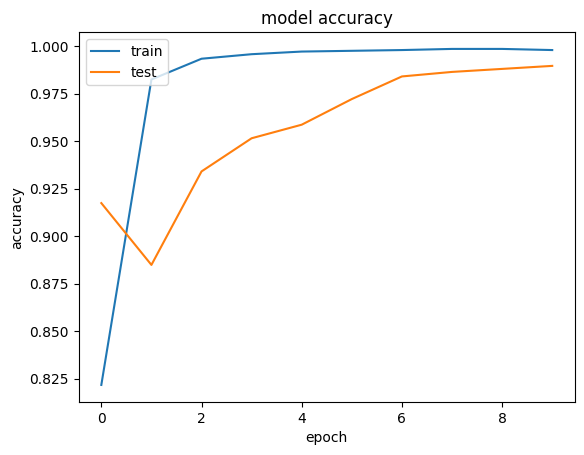

In [40]:
# SOLUTION
for i, history in enumerate(histories):
    print("Model",i)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [41]:
# SOLUTION
for i, model in enumerate(models):
    print("Model",i)
    train_loss, train_acc = model.evaluate(xtrain, ytrain)
    print('Test accuracy:', train_acc)
    test_loss, test_acc = model.evaluate(xtest, ytest)
    print('Test accuracy:', test_acc)

Model 0
158/158 [==============================] - 2s 11ms/step - loss: 0.0114 - accuracy: 0.9946
Test accuracy: 0.9946407079696655
40/40 [==============================] - 0s 11ms/step - loss: 0.0275 - accuracy: 0.9897
Test accuracy: 0.9896825551986694


Model 0
40/40 [==============================] - 0s 11ms/step


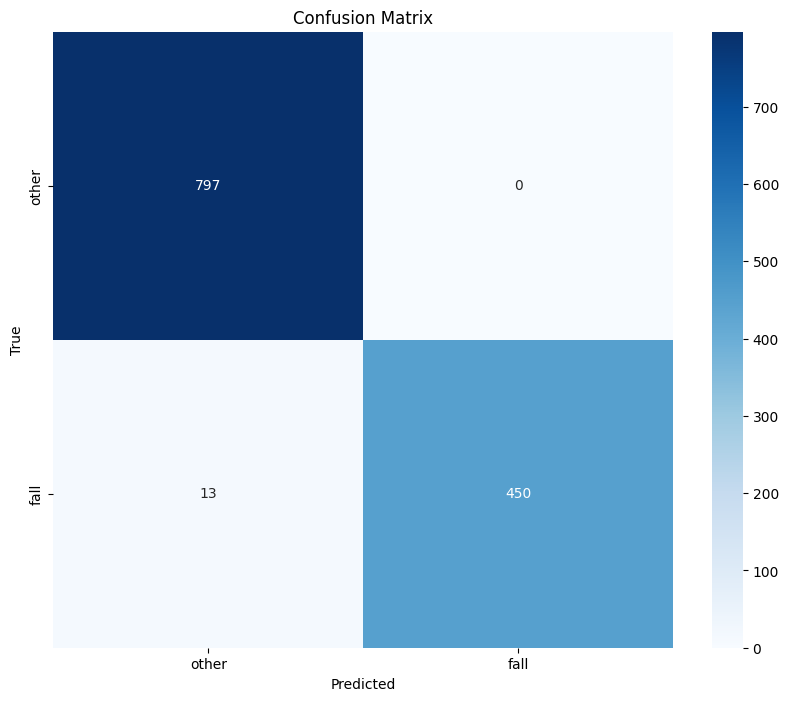

In [42]:
# SOLUTION
for i, model in enumerate(models):
    print("Model",i)
    # Predict classes
    predictions = model.predict(xtest)
    # Convert predictions classes from one hot encodings to labels
    predicted_classes = np.argmax(predictions, axis=1)
    # Convert test labels from one hot encodings to labels if necessary
    true_classes = np.argmax(ytest, axis=1)

    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Label names (replace with your labels)
    class_labels = ['other', 'fall']
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

- **TODO: Questions:**
    - which model is the best ? (also take the number of parameters into account)
    - did you observe underfitting/overfitting on some models ?

- **TODO: Final evaluation of the selected model:**
    - load the data (pickle file) from the test set with images 96 x 96 px
    - transform the labels with *to_categorical*
    - evaluate the performance of the model you selected on this final test set
    - are your satisfied ?

In [43]:
# TODO

In [44]:
# SOLUTION
# final_model = models[3]
# final_history = histories[3]
final_model = models[0]
final_history = histories[0]
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 batch_normalization_1 (Bat  (None, 94, 94, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 batch_normalization_2 (Bat  (None, 45, 45, 32)        128       
 chNormalization)                                                
                                                      

In [45]:
# SOLUTION
with open("data_test_96_96_3.pickle", 'rb') as file:
    train_dict = pickle.load(file)
X_final = train_dict['data']
for i,x in enumerate(X_final):
    X_final[i] = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
# y_complete = train_dict['labels'][BATCH]
y_final = train_dict['labels']
width = train_dict['width']
height = train_dict['height']
channels = train_dict['channels']

# Convert labels to categorical (one-hot encoding)
y_final = to_categorical(y_final)

40/40 [==============================] - 0s 11ms/step


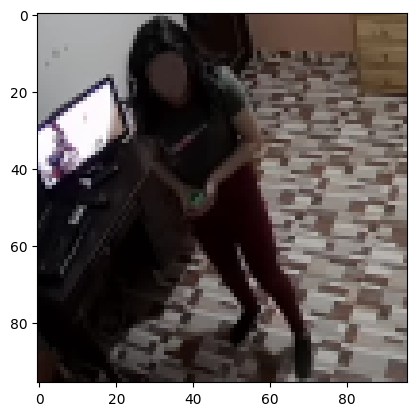

[3.2547079e-05 9.9996746e-01]
[1. 0.]


In [46]:
# SOLUTION
ypred = final_model.predict(xtest)
# images = X.reshape((-1, 28, 28))
plt.imshow(X_final[0],cmap=plt.cm.gray_r,interpolation="nearest")
plt.show()
print(ypred[0])
print(y_final[0])

In [47]:
# SOLUTION
final_loss, final_acc = final_model.evaluate(X_final, y_final)
print('Final accuracy:', final_acc)

62/62 [==============================] - 1s 11ms/step - loss: 66.3533 - accuracy: 0.4680
Final accuracy: 0.4679979383945465


62/62 [==============================] - 1s 11ms/step


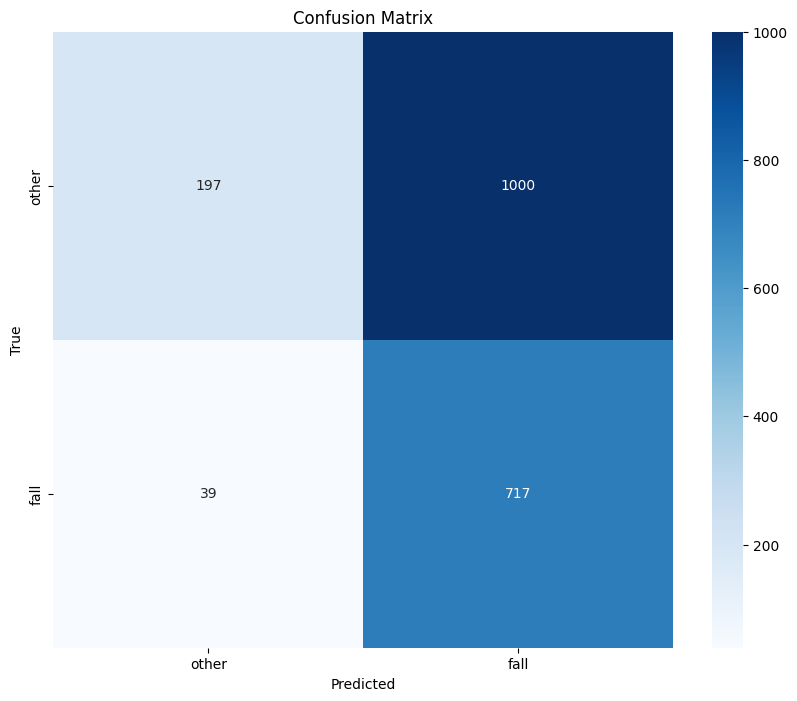

In [48]:
# SOLUTION
# Predict classes
predictions = final_model.predict(X_final)
# Convert predictions classes from one hot encodings to labels
predicted_classes = np.argmax(predictions, axis=1)
# Convert test labels from one hot encodings to labels if necessary
true_classes = np.argmax(y_final, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Label names (replace with your labels)
class_labels = ['other', 'fall']
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

- save your model to the file "best_CNN.keras"

In [49]:
final_model.save("best_CNN.keras")